In [618]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

Prior: (naturalness)
$$prior(\boldsymbol{a}|M,R)=(\frac{1}{\sqrt{2\pi}R})^{M+1}exp(-\frac{\boldsymbol{a}^2}{2R^2})

$$

generate data from function $g(x)=(\frac{1}{2}+tan(\frac{\pi}{2}x))^2$(which is precise value)  
with relative error of each 'experimental points' being constant $c$  
the number of mesh (or $x$ points) $N$

In [619]:
def g(x):
    return (0.5 + np.tan(np.pi * x / 2))**2

c=0.05
N=10

generate mesh $x$ within domain $D_2=[0,\frac{2}{\pi}]$, $N$ points  

In [620]:
x=np.linspace(2/np.pi/10,2/np.pi,N)
print('x:')
print(x)
print('x*pi/2:')
print(x*np.pi/2)

x:
[0.06366198 0.12732395 0.19098593 0.25464791 0.31830989 0.38197186
 0.44563384 0.50929582 0.5729578  0.63661977]
x*pi/2:
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


eta is used to generate 'experiment data' (virtually), which follows a normal distribution, for each data point there is a corresponding $\sigma_{\eta_i}$    
$\sigma_{\eta}=1,\bar{\eta}=0$, $\eta \sim N(0,\sigma_\eta)$  
then generate 'data points' by $y(x_i)=g(x_i)(1+c\eta_i)$  
and $\sigma_i=cy(x_i)$

In [621]:
sigma_eta=1
eta=np.random.normal(0,sigma_eta,N)
y=g(x)*(1+c*eta)
sigma=c*y
#-----------------------------------
print('y:')
print(y)
print('sigma:')
print(sigma)

y:
[0.35700792 0.50850839 0.63587533 0.78909206 1.14264928 1.40182223
 1.89333646 2.52435106 3.0216118  4.39304129]
sigma:
[0.0178504  0.02542542 0.03179377 0.0394546  0.05713246 0.07009111
 0.09466682 0.12621755 0.15108059 0.21965206]


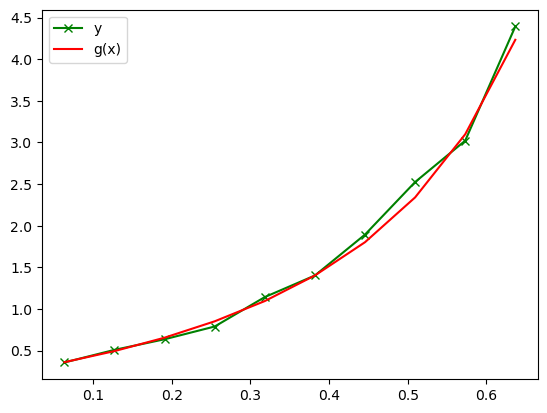

In [622]:
plt.plot(x,y,'gx-',label='y')
plt.plot(x,g(x),'r-',label='g(x)')
plt.legend()

plt.show()

order of polynominal $M$  
sample parameter($M+1$ rows, $N_{par}$ columns)  
$Npar$ parameters for each $a_i$  
$R$: standard deviation parameter in the prior

In [623]:
M=5
Npar=10
R=5
# params=[]
# for _ in range(M+1):
#     param_values=np.linspace(-5,5,Npar)
#     params.append(param_values)

# params = np.array(params)
def generate_samples(M, R, num_samples):
    # Generate samples from the Gaussian distribution
    samples = np.random.normal(0, R, size=(M+1, num_samples))
    
    return samples
    
params=generate_samples(M, R, Npar)
print('params:')
print(params)

params:
[[ -0.03819536  11.00337053  -0.96723738   2.85273582   1.64541601
   -0.14320489  -0.72774347   1.32587508   3.57398535  -4.2242621 ]
 [ -2.26055035  -3.13582254  -0.58139191  -2.11313551  -4.04860401
    2.8268529   -8.21705717  -3.7615731    8.55501032  -1.90118807]
 [  3.29897907   4.01122462  -3.58732394  -2.31238449  -8.77258997
    1.65728311   2.04219156  -1.01500413   3.94903364   0.59712325]
 [  0.23758497  -4.38530278  -1.69691293  -3.32552307  -1.13811063
   -4.63251842  -0.1258595    0.68553088   0.18186781   1.95788451]
 [  2.02571118   6.36882946   3.20505211  -6.90014428   9.36472463
    2.1505914    0.69514515 -10.78621251   0.09092719   8.32228902]
 [  1.66628444   7.60585754   6.25961103  -5.91780832   2.00345613
   -4.05027343   3.65965981  -3.82630056   3.40384173   2.2758123 ]]


define polynominal function  
chi square: $\chi^2=\sum_{i} \frac{(y_i-f_i)^2}{\sigma_i^2} $  
likelihood: $p(D|\alpha)\propto exp(-\frac{1}{2}\chi^2)$

In [624]:
#def polynomial function
def polynomial(para,x):
    return np.polyval(para,x)

#def chi-square function
def chi_square(y, f, sigma):
    return np.sum(((y-f)**2)/sigma**2)

#def likelyhood function
def likelihood(y, f, sigma):
    chi_sq = chi_square(y, f, sigma)
    return np.exp(-0.5 * chi_sq)
    
#def log_posterior
def log_posterior(a, x, y, sigma, R):
    model = polynomial(a, x)  
    return -0.5 * (np.sum(a**2)/ R**2 + chi_square(y, model, sigma))

In [625]:
nwalkers = 32
a = np.random.rand(nwalkers, M+1)*2

In [626]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, M+1, log_posterior, args=[x,y,sigma,R],a=4)


In [627]:
log_posterior(a[0], x, y, sigma, R)

-6042.304726324864

In [628]:
state = sampler.run_mcmc(a, 500)
sampler.reset()

In [629]:
sampler.run_mcmc(state, 20000);

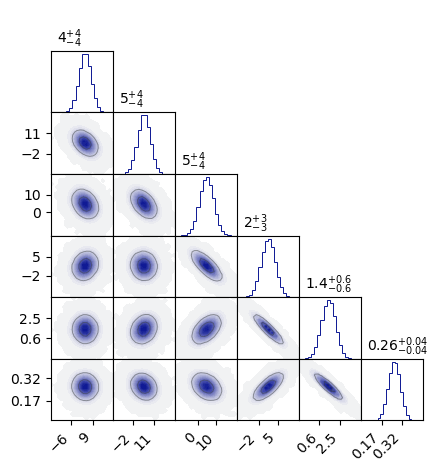

In [630]:
import prettyplease
samples = sampler.get_chain(flat=True)
# plt.hist(samples[:,4], 100, color="k", histtype="step", density=True)
# plt.xlabel(r"$\theta$")
# plt.ylabel(r"$p(\theta|D)$")
#plt.gca().set_yticks([]);
fig = prettyplease.corner(samples)
plt.show()  

In [631]:
print(
    "Mean acceptance fraction: {0:.3f}".format(
        np.mean(sampler.acceptance_fraction)
    )
)
print(
    "Mean autocorrelation time: {0:.3f} steps".format(
        np.mean(sampler.get_autocorr_time())
    )
)

Mean acceptance fraction: 0.516
Mean autocorrelation time: 72.551 steps


In [632]:
# 假设你已经有一个名为 sampler 的采样器对象

# 获取所有链的数据
chain = sampler.get_chain()

# `chain` 的形状是 (nsteps, nwalkers, ndim)
# 我们需要将其重塑为 (nsteps * nwalkers, ndim)，这样每行就是一个参数向量
flattened_chain = chain.reshape(-1, chain.shape[2])

# 打印所有参数向量
print(flattened_chain)

[[13.04023473  2.39730831  2.02429153  1.59969806  1.61603252  0.26219241]
 [ 0.32086071  7.20437032  4.8846796   1.54940108  1.54879275  0.25037799]
 [ 2.33037481  3.13581027  7.21597112  0.21072692  1.52714324  0.29222494]
 ...
 [ 6.0042457   7.25899887  0.90735861  2.40197643  1.38491623  0.25916279]
 [ 4.45023987 -0.97265084 -0.126181    8.57565819 -0.11502622  0.32184571]
 [-2.12383854 10.50470527  7.24566424 -1.85998759  2.18235923  0.23629073]]


In [633]:
# likelihoods = np.zeros((Npar,) * (M+1))
# posterior = np.zeros((Npar,) * (M+1))
# print(likelihoods.shape)

Create a zero parameter array

In [634]:

# para=np.zeros(M+1)
# print(para.shape)
# print(para)

 遍历所有参数的组合  
 选择参数  
 计算模型的预测值  
 计算似然函数值  

In [635]:

# for index in itertools.product(range(Npar), repeat=M+1):
    
#     for i in range(params.shape[0]):
#         para[i]=params[i,index[i]]
#    # para = params[:, index]
    
#     f = polynomial(para, x)
    
#     likelihoods[index] = likelihood(y, f, sigma)
#     posterior[index] = likelihoods[index] * prior(para, M, R)
    
#     print(posterior[index])

# print(posterior.max()) 